In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, QFT
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


from sklearn.preprocessing import MinMaxScaler


from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

In [3]:
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

In [4]:
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window

conjunto_train = []
objetivo_train = []

conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])
    
for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])

objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

In [5]:
scaler = MinMaxScaler((0.3, np.pi-0.3))
conjunto_train = scaler.fit_transform(conjunto_train)

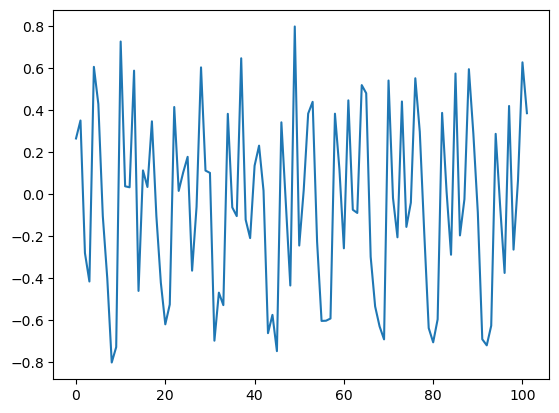

In [6]:
objetivo_train = (-1.6/(np.min(objetivo_train) - np.max(objetivo_train)))*objetivo_train - 0.8 + np.min(objetivo_train)*(1.6/(np.min(objetivo_train) - np.max(objetivo_train)))
plt.plot(objetivo_train)
plt.show()

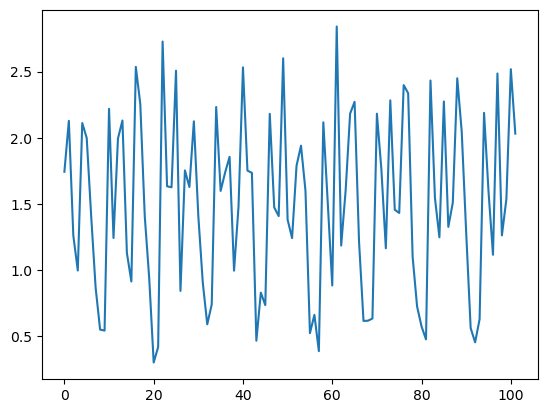

In [7]:
plt.plot(conjunto_train[:,0])
plt.show()

In [8]:
def circuitoRegresor_CodificacionAngular(n_qubits=1):
    qc = QuantumCircuit(n_qubits)
    
    inputs = ParameterVector("inputs",n_qubits)
    pesos = ParameterVector("pesos",2*n_qubits)
    feature_map = QuantumCircuit(n_qubits)
    feature_map.h(range(n_qubits))
    
    
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
        
    for i in range(n_qubits-1):
        feature_map.cx(i,i+1)
    
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
    
    ansatz = RealAmplitudes(n_qubits)
    #ansatz = QuantumCircuit(n_qubits)
    #for i in range(n_qubits):
    #    ansatz.ry(pesos[i],i)
    #    
    #for i in range(n_qubits-1):
    #    ansatz.cz(i,i+1)
    #
    #for i in range(n_qubits,2*n_qubits):
    #    ansatz.ry(pesos[i],i-n_qubits)
        
    
    
    qc.compose(feature_map, inplace=True)
    qc.compose(QFT(n_qubits, inverse = True), inplace=True)
    qc.compose(ansatz, inplace=True)
    
    
    
    
    return feature_map.parameters, ansatz.parameters, qc, feature_map, ansatz

In [9]:
inputs, params, circuito, f1, f2 = circuitoRegresor_CodificacionAngular(window)

In [10]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [11]:
modeloEstimator = EstimatorQNN(
        circuit=circuito, input_params=inputs, weight_params=params
    )

In [12]:
regressor = NeuralNetworkRegressor(
    neural_network=modeloEstimator,
    loss='absolute_error' ,
    optimizer=COBYLA(maxiter=1000),
    callback=callback_graph
)

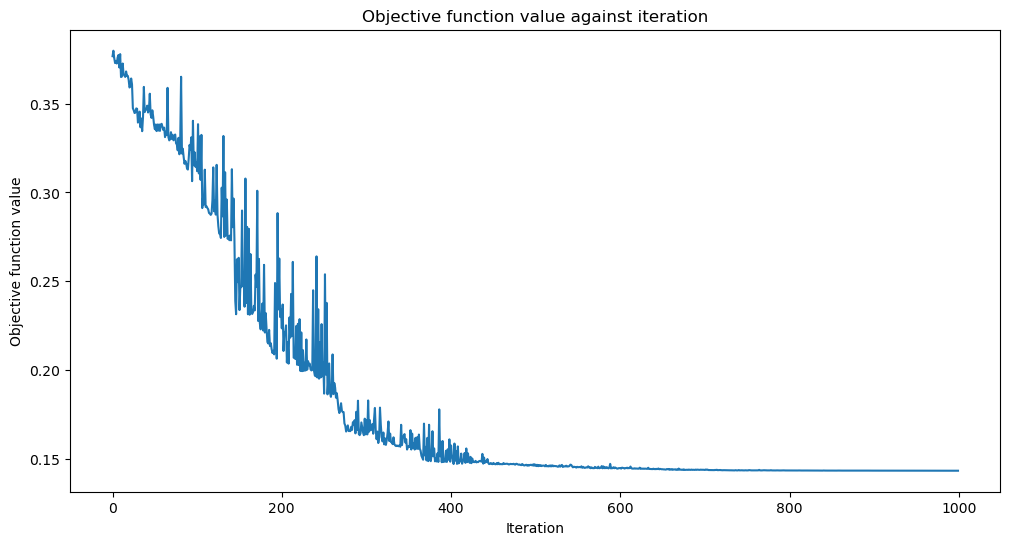

0.8131925011006076

In [13]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(conjunto_train, objetivo_train)
regressor.score(conjunto_train, objetivo_train)

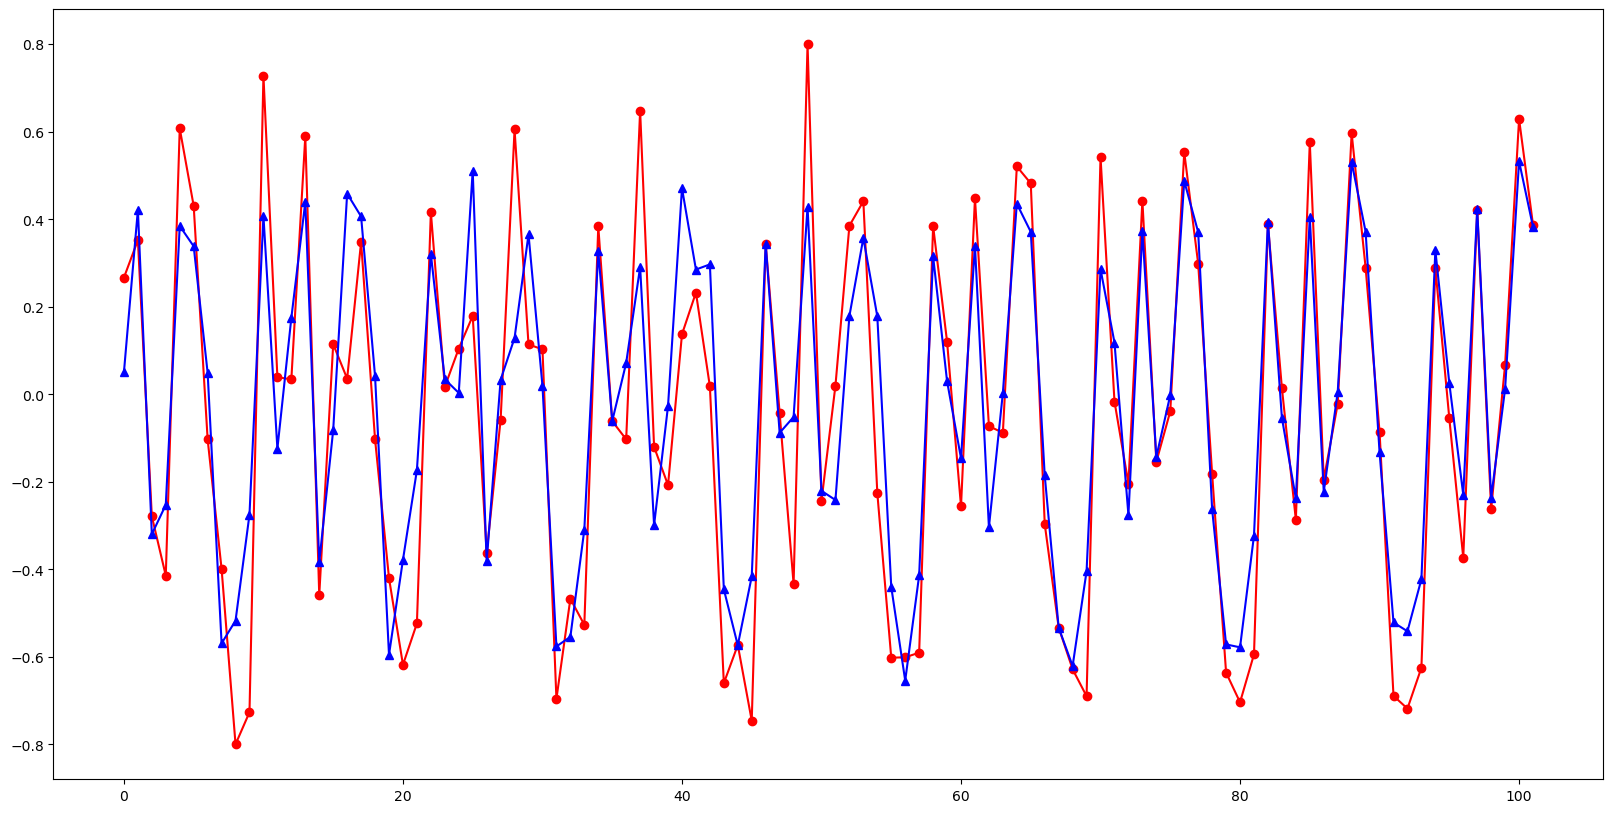

array([ 5.66334668e-01,  1.39107655e+00,  9.06588805e-01, -9.24200855e-01,
       -2.48942350e-01,  8.39987879e-01,  2.91795002e-01,  1.74205720e+00,
        1.26321992e+00,  9.60407193e-01,  1.17506911e+00,  1.11887702e-02,
        2.71342667e-01,  4.67768445e-01, -1.22437378e-03,  2.04710388e-01,
        1.42986705e+00,  2.38168165e+00,  1.45158646e+00,  9.87320391e-01,
        1.24934879e+00,  1.07967325e+00, -5.77556343e-01,  2.51918872e+00,
        2.40556236e+00,  1.40246859e+00,  1.05033624e+00,  2.13559670e+00,
        2.26113073e+00,  4.23230800e-01,  5.64481155e-01,  7.11994229e-01,
        1.80450695e+00, -1.33590506e-01,  1.56826872e+00,  1.48294970e+00,
        2.36342374e-02,  5.48668533e-03, -1.87268891e-02,  1.46874928e-02,
       -5.36640336e-03,  6.46951077e-02, -6.02472666e-02,  2.56095458e-02,
        1.63554468e-01, -8.66173234e-02,  8.93872502e-01,  1.35458410e-01])

In [18]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor.weights

In [19]:
np.sum( np.abs(objetivo_train[:] - y_[:]))/(len(objetivo_train))

45.812309384338064

In [15]:
vqr = VQR(
    feature_map=f1,
    ansatz=f2,
    optimizer=COBYLA(maxiter=2000),
    callback=callback_graph,
    loss='absolute_error' ,
)

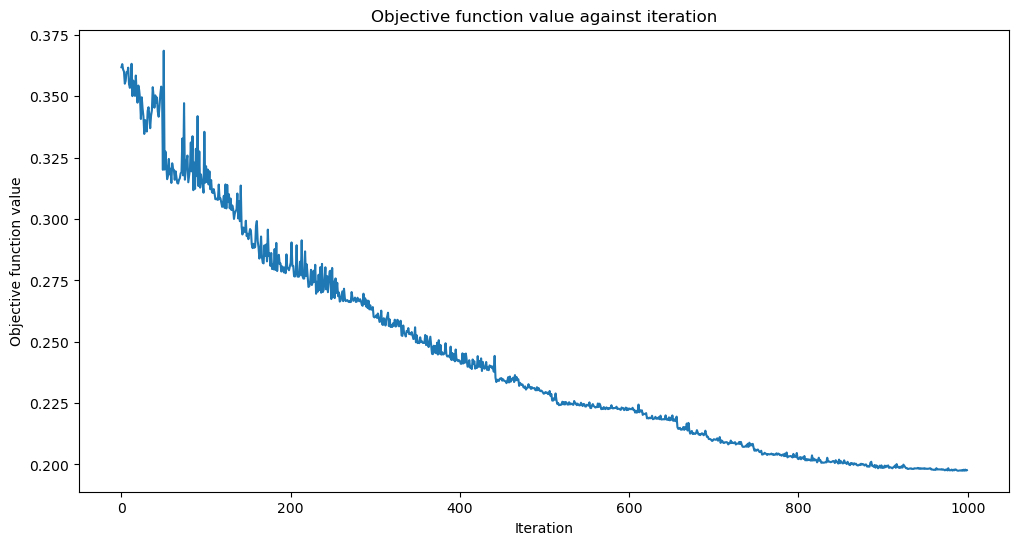

0.5921280864334637

In [16]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(conjunto_train, objetivo_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(conjunto_train, objetivo_train)

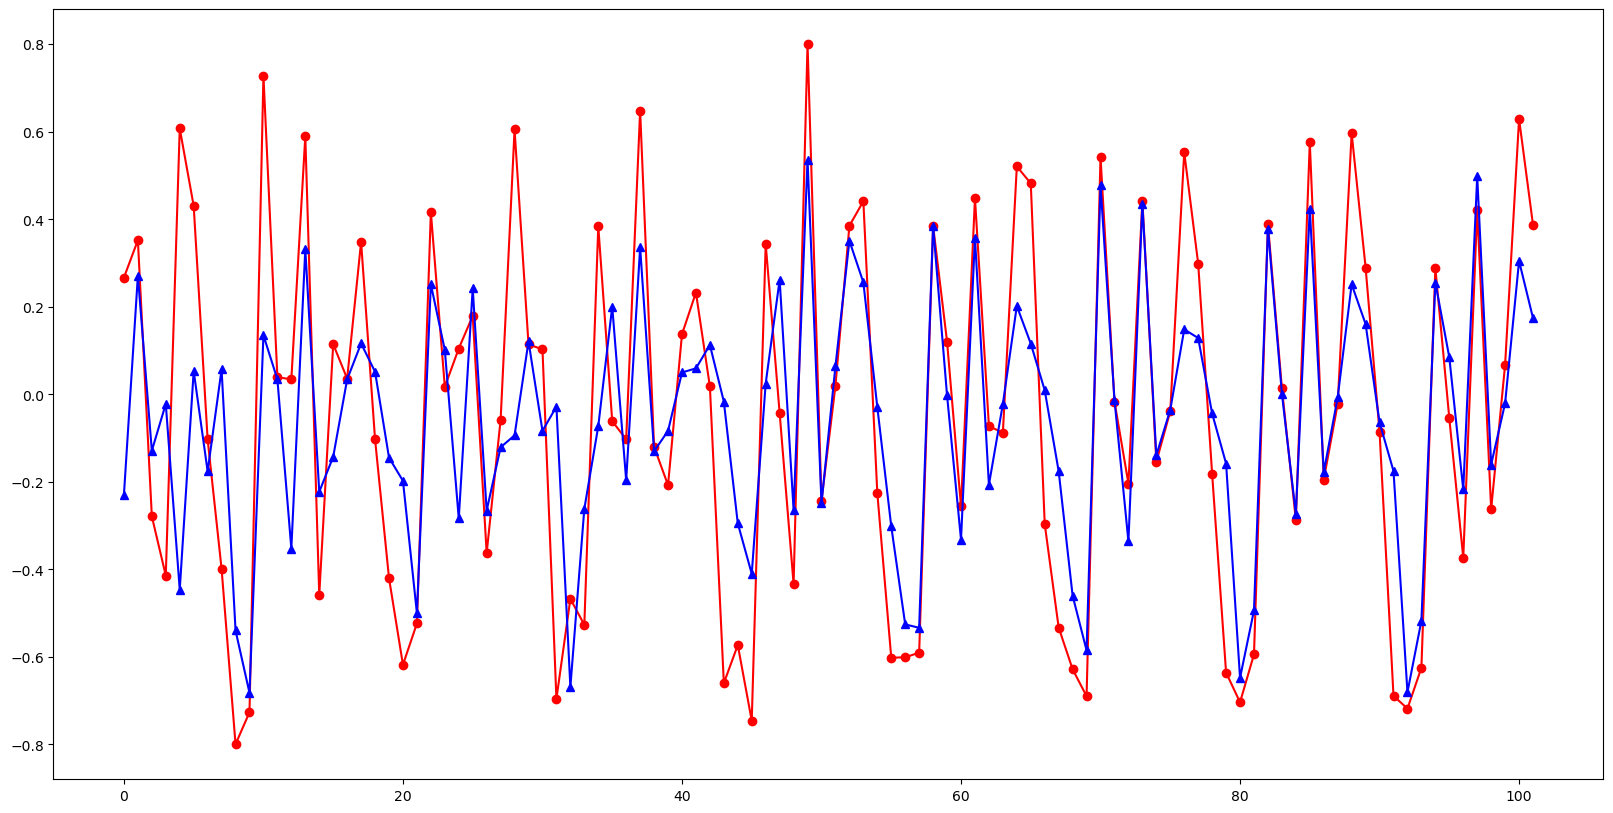

42.814539474143075

In [17]:
plt.figure(figsize=(20,10))
espacio = np.arange(0,conjunto_train.shape[0])
y_ = vqr.predict(conjunto_train)
plt.plot(espacio[:] ,objetivo_train[:], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[:],(y_[:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( np.abs(objetivo_train[:] - y_[:]))/(len(objetivo_train))